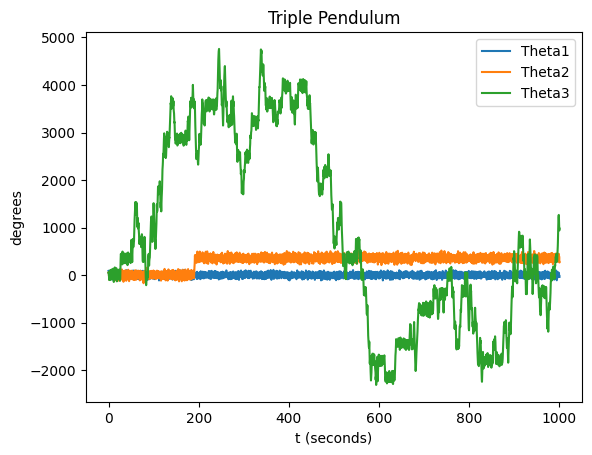

In [1]:
from __future__ import division, print_function
from math import sin, cos, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score

g = 9.81
l1 = 1
l2 = 1
l3= 1
m1 = 1.0
m2 = 1.0
m3 = 1.0

def f(q, t):
    '''Triple Pendulum equation of motion'''

    # Define relevant parameters

    # Define useful mass combinations
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012/4

    # Define useful sines
    sin0 = np.sin(q[0])
    sin1 = np.sin(q[2])
    sin2 = np.sin(q[4])

    # Define useful sine and cosine of differences
    cos01 = np.cos(q[0]-q[2])
    cos02 = np.cos(q[0]-q[4])
    cos12 = np.cos(q[2]-q[4])
    sin01 = np.sin(q[0]-q[2])
    sin02 = np.sin(q[0]-q[4])
    sin12 = np.sin(q[2]-q[4])

    # Define useful recurrent patterns
    r1 = m12*cos01*cos02 - m012*cos12
    r2 = m012 - m12*(cos01)**2
    r3 = -m012 + m3*(cos02)**2

    # Define parts of the first equation
    od1_1 = 4*m3*m12
    od1_2 = r1*cos01 + r2*cos02
    od1_3 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od1_4 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2
    od1_5 = -m3*m12*( -cos02 + np.cos(q[0]-2*q[2]+q[4]) )**2 * m012
    od1_6 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od1_7 = m3*r1**2 + m12*r3*r2

    # Define parts of the second equation
    od2_1 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od2_2 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od2_3 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2

    # Define parts of the thirds equation
    od3_1 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od3_2 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od3_3 = g*m2*sin1 + g*m3*sin1 - l1*m2*sin01*q[1]**2 - l1*m3*sin01*q[1]**2 + l3*m3*sin12*q[5]**2

    # ThetaDot equations
    td1 = q[1]
    td2 = q[3]
    td3 = q[5]

    # OmegaDot equations
    od1 = mf * ( od1_1 * od1_2 * od1_3 * r2 - 4 * ( -m3 * od1_2 * r1 + ( m3 * r1**2 + m12 * r3 * r2 ) * cos01 ) * od1_4 - ( od1_5 + 4*m3*r1**2 + 4*m12*r3*r2 ) * od1_6 ) / ( l1 * od1_7 * m012 * r2)
    od2 = ( -m3 * r1 * m012 * od2_1 * r2 - ( m3 * ( r1*cos01 + r2*cos02 ) * r1 - ( m3*r1**2 + m12*r3*r2 ) * cos01 ) * od2_2 + m012*r3*r2*od2_3 ) / ( l2 * od1_7 * r2 )
    od3 = -( m12 * (od1_2) * (od3_1) + m12 * m012 * (od3_2) * r2 - r1*m012 * od3_3 ) / ( l3 * ( m3*r1**2 + m12*r3*r2 ) )

    return np.array([td1, od1, td2, od2, td3, od3])

a = 0.0
b = 1000
N = 1000000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)  # Preallocate arrays with zeros
theta2_points = np.zeros_like(tpoints)
theta3_points = np.zeros_like(tpoints)

q = np.array([np.pi / 2, 0, np.pi / 3, 0, np.pi / 4, 0], float)  # Initial conditions

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / np.pi  # Convert to degrees
    theta2_points[i] = q[2] * 180 / np.pi
    theta3_points[i] = q[4] * 180 / np.pi

    k1 = h * f(q, t)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(q + k3, t + h)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.plot(tpoints, theta3_points, label='Theta3')
plt.title("Triple Pendulum")
xlabel("t (seconds)")
ylabel("degrees")
plt.legend()
plt.show()

In [2]:
data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
np.save('pendulum_data.npy', data)

data = np.load('pendulum_data.npy')

# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# create the sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch 1 Train Loss: 1.192490, Val Loss: 0.031727
Epoch 2 Train Loss: 0.006128, Val Loss: 0.000037
Epoch 3 Train Loss: 0.000019, Val Loss: 0.000011
Epoch 4 Train Loss: 0.000008, Val Loss: 0.000007
Epoch 5 Train Loss: 0.000005, Val Loss: 0.000005
Epoch 6 Train Loss: 0.000004, Val Loss: 0.000004
Epoch 7 Train Loss: 0.000004, Val Loss: 0.000003
Epoch 8 Train Loss: 0.000003, Val Loss: 0.000003
Epoch 9 Train Loss: 0.000003, Val Loss: 0.000003
Epoch 10 Train Loss: 0.000003, Val Loss: 0.000003
Epoch 11 Train Loss: 0.000003, Val Loss: 0.000003
Epoch 12 Train Loss: 0.000003, Val Loss: 0.000003
Epoch 13 Train Loss: 0.000003, Val Loss: 0.000003
Epoch 14 Train Loss: 0.000003, Val Loss: 0.000003
Epoch 15 Train Loss: 0.000003, Val Loss: 0.000003
Epoch 16 Train Loss: 0.000003, Val Loss: 0.000003
Epoch 17 Train Loss: 0.000002, Val Loss: 0.000002
Epoch 18 Train Loss: 0.000002, Val Loss: 0.000003
Epoch 19 Train Loss: 0.000002, Val Loss: 0.000003
Epoch 20 Train Loss: 0.000002, Val Loss: 0.000002
Epoch 21 

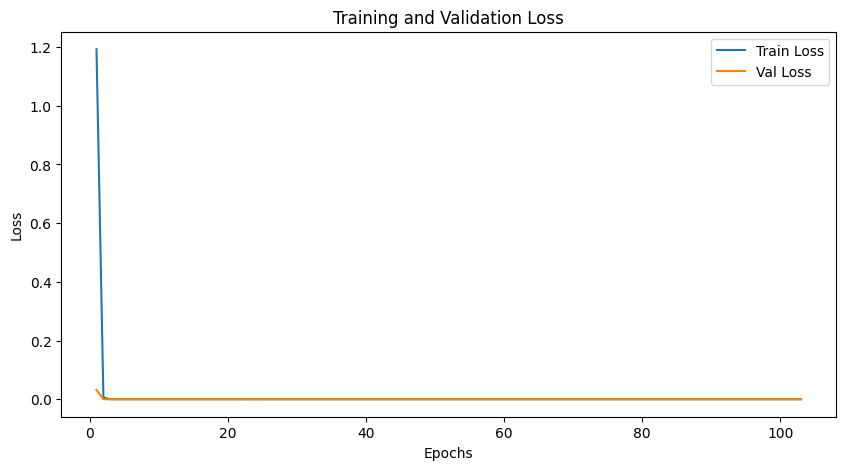

Test RMSE: 0.001275469083338976
Test R^2 Score: 0.999963918492239


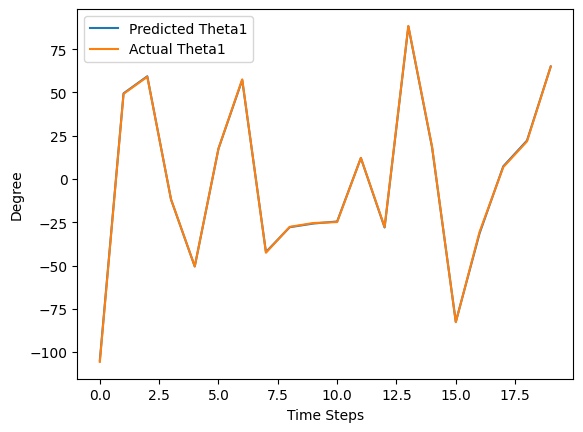

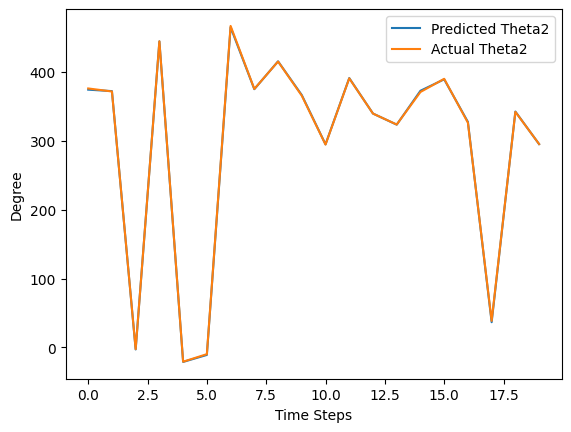

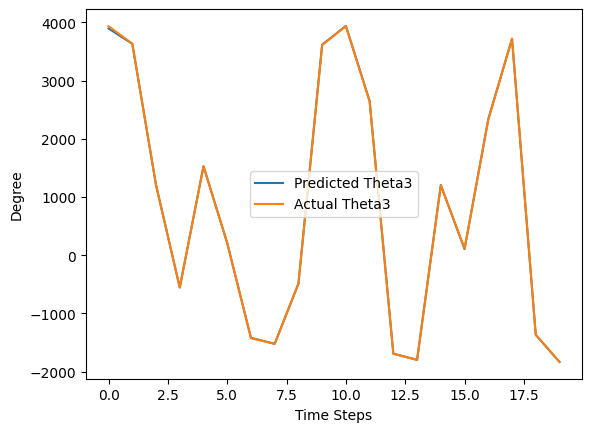

In [3]:
class AutoregressiveModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AutoregressiveModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, criterion, optimizer setup
input_dim = 3
hidden_dim = 50
output_dim = 3
model = AutoregressiveModel(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)

# Weights and Biases Initialization
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)
    elif 'bias' in name:
        nn.init.uniform_(param, -5, 5)

# Early stopping variables
num_epochs = 150
patience = 20
best_loss = float('inf')
patience_counter = 0

#store losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item() * data.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)


    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data_val, targets_val in test_loader:
            data_val, targets_val = data_val.to(device), targets_val.to(device)
            outputs_val = model(data_val)
            loss_val = criterion(outputs_val, targets_val)
            val_loss += loss_val.item() * data_val.size(0)

    avg_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1} Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after epoch {epoch+1}')
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred.append(outputs.cpu().numpy())
        y_true.append(targets.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Calculate performance
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f'Test RMSE: {rmse}')
print(f'Test R^2 Score: {r2}')

# Inverse transform the predictions and true values
y_pred = scaler.inverse_transform(y_pred)
y_true = scaler.inverse_transform(y_true)

#Plot actual vs predicted angles
plt.plot(y_pred[0:20, 0], label='Predicted Theta1')
plt.plot(y_true[0:20, 0], label='Actual Theta1')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

plt.plot(y_pred[0:20, 1], label='Predicted Theta2')
plt.plot(y_true[0:20, 1], label='Actual Theta2')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()

plt.plot(y_pred[0:20, 2], label='Predicted Theta3')
plt.plot(y_true[0:20, 2], label='Actual Theta3')
plt.xlabel('Time Steps')
plt.ylabel('Degree')
plt.legend()
plt.show()